# Table of Contents
- [Introduction](#introduction)
    - [Load the data](#load-the-data)
    - [Plotting of the data](#plotting-of-the-data)
- [REFERENCES](#references)

# Introduction
This contains the code for section 1 Part 1 of the kaggle mini project. In here, I perform exploratory data analysis of the BBC data and create features out of the text in each article. The analysis is performed for the train data set.

## Load the data
This section of the code loads the data for the analysis

In [16]:
# import all libraries used in this code

import pandas as pd
import matplotlib.pyplot as plt

In [17]:
#load the training data
df_train = pd.read_csv("data/BBC News Train.csv")

#factorize the article categories in order to make the prediction a lot easier
df_train['category_id'] = df_train.Category.factorize()[0]

#keep a key dictionary of the factorize operation just in case
#filter the ids and categories to not have repetition
track_item = set()
id_list = [id for id in df_train.Category.factorize()[0] if id not in track_item and not track_item.add(id)]
track_cat = set()
cat_list = [cat for cat in df_train.Category.factorize()[1] if cat not in track_cat and not track_cat.add(cat)]
category_to_id = dict(zip(id_list, track_cat))

## Plotting of the data
Let's create some plots about the number of documents per class, and also do some initial data description stats

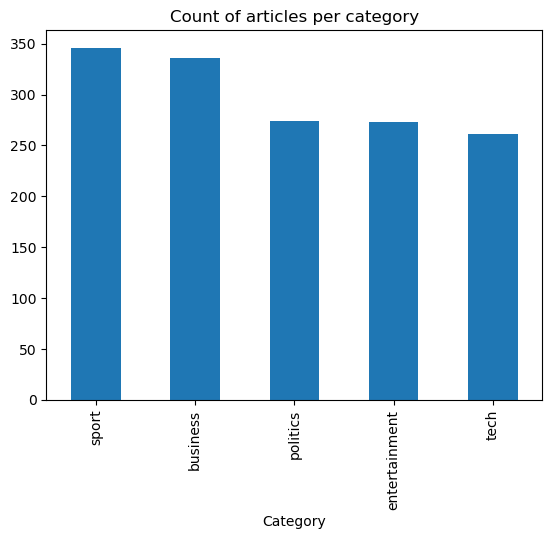

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   category_id  Word_count  
0            0        1866  
1            0        2016  
2            0        3104  
3            1        3618  
4            0        2190  


In [25]:
df_train.Category.value_counts().plot(kind='bar',title="Count of articles per category")
plt.show()

# lets also print the first 5 entries of the dataframe
print(df_train.head())

# do initial stats on the data: count the total number of words per category and then the min, mean, and max across the articles
df_train['Word_count'] = [len(article_words) for article_words in df_train.Text]




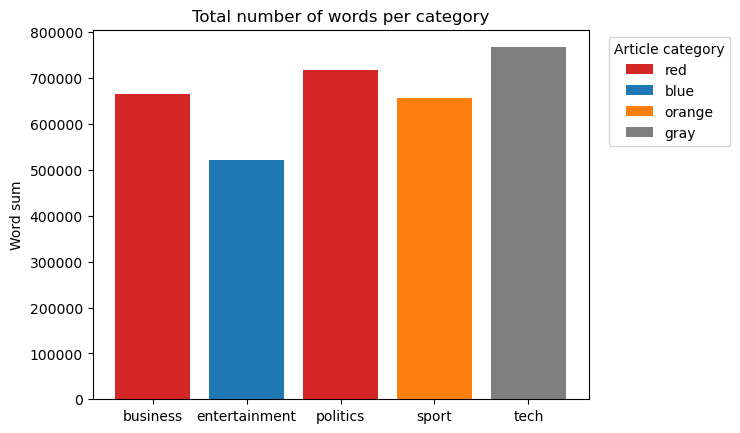

In [59]:
stats_to_plot = df_train.groupby(['Category', 'category_id'], as_index=False)['Word_count'].agg(['min', 'max', 'mean', 'sum'])

stats_to_plot

fig, ax = plt.subplots()
bar_labels = ['red', 'blue', '_red', 'orange', 'gray']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:gray']
ax.bar(stats_to_plot['Category'], stats_to_plot['sum'], label=bar_labels, color=bar_colors)
ax.set_ylabel('Word sum')
ax.set_title('Total number of words per category')
ax.legend(title='Article category', loc = 1, bbox_to_anchor = (1.3, 1))


After doing some initial data analysis, we need to tokenize the words for each article to be able to meaningfully train an AI model on the data to make accurate predictions. Tne approach I use a *"bag of words"* model: for each article, the presence and frequency of words is taken into consideration, but the order in which they occur is ignored.

The model calculates *Term Frequency, Inverse Document Frequency*. This stat represents word importance in each document; the word frequency is used as a proxy for its importance, and document frequency (the number of documents containing a given word) as a measure of how common the word is, which minimizes the effect of stop-words.


**REFERENCES:**
* https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification: used this document as a guidance for the steps I should take during this exercise